In [5]:
%reset -f

# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Monday, October 21, 2024, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a Neural Network (MLP). This is similar to a problem you have worked on before but requires the use of a neural network model.

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/6610d6c6ba314eac9ead0b7a47695700
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  



> Good luck, comrade!

---


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a neural network (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering. So the manual feature engineering is not allowed!
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Enhance performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning training hyperparameters.

> Note: There are no restrictions on the tricks you can use — just achieve the required accuracy. Stack more layers, use AdamW, scheduling, ect. Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How did you achieve the reproducibility of the results?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between the SGD and Adam optimizers.
   - Visualize the learning rate dynamics. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct an ablation study of each architectural and optimization choice concerning test accuracy.


In [7]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

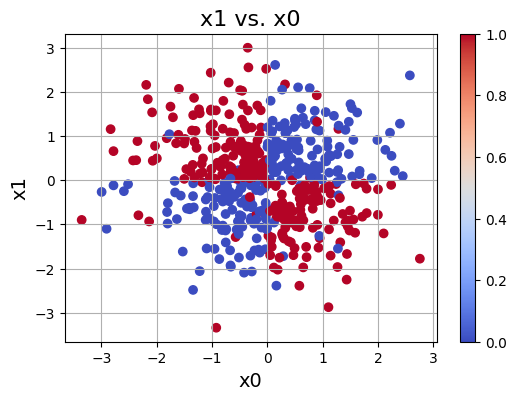

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

In [9]:
import torch
import torch.nn.functional as F
from torch import nn

In [10]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train'].drop(columns='split')
test = data[data['split'] == 'test'].drop(columns='split')
train.head()

,x0,x1,y
0,0.377044,0.587023,0.0
1,-1.222865,1.514124,1.0
2,-0.036282,-1.562136,0.0
3,-1.217459,0.151372,1.0
4,0.072188,0.503239,0.0


In [11]:
class Model(nn.Module):
    # Input layer (2 features) -->
    # Hidden layer 1 [h1] (number of neurons) -->
    # h2 (n) --> 
    # output (binary classification)
    def __init__(self, in_features=2, h1=8, h2=9, out_features=2) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.out(x))
        
        return x

In [12]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# To numpy array
X_train = train.drop(columns='y').values
y_train = train['y'].values
X_test = test.drop(columns='y').values
y_test = test['y'].values

# To tensor
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

### Manual learning rate

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
torch.manual_seed(28)
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
epochs = 4000
losses = []
verbose = 0

for i in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().cpu().numpy())

    if i%100 == 0 and verbose:
        print(f'Epoch: {i}, loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

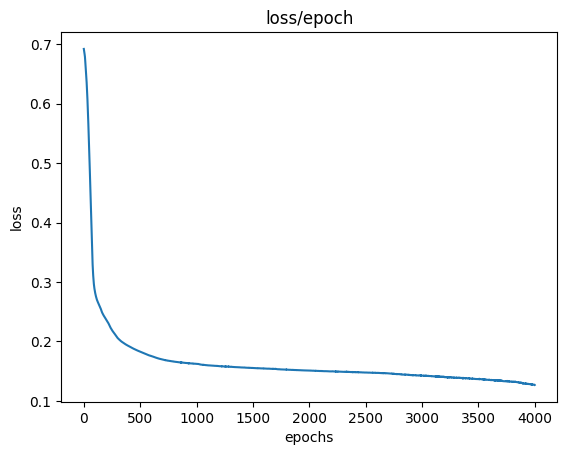

In [16]:
sns.lineplot(x=range(epochs), y=np.array(losses))
plt.xlabel('epochs')
plt.title('loss/epoch')
plt.ylabel('loss')
plt.show()

In [17]:
with torch.no_grad():
    model.eval()
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)

correct = 0
for i, y_val in enumerate(y_eval):
    if y_val.argmax().item() == y_test[i]:
        correct+=1

print(f'Accuracy: {correct/y_test.shape[0]}')

Accuracy: 0.928


### Self implemented warmup cosine decay

In [18]:
# Reset model
import random
seed = 28 #random.randint(0,1e6) #531055
torch.manual_seed(seed)
model = Model().to(device)
print(seed)

28


In [19]:
from _lr_scheduler import WarmupCosineDecay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
epochs_scheduler = 1000
scheduler = WarmupCosineDecay(optimizer, warmup_steps=epochs_scheduler*0.01, total_steps=epochs_scheduler, min_lr=1e-4)
losses_scheduler = []
learning_rates = []
verbose = 0

for i in range(epochs_scheduler):
    model.train()
    
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses_scheduler.append(loss.detach().cpu().numpy())
    learning_rates.append(scheduler.get_lr())
    if i%100 == 0 and verbose:
        print(f'Epoch: {i}, loss: {loss}, lr: {scheduler.get_lr()}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

In [20]:
def accuracy(y_predicted, y_correct):
    predicted_labels = torch.argmax(y_predicted, dim=1).cpu().numpy()
    return (predicted_labels==y_correct.cpu()).sum()/y_correct.cpu().shape[0]

In [21]:
with torch.no_grad():
    model.eval()
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)

print(f'Accuracy: {accuracy(y_eval, y_test)}')

Accuracy: 0.9160000085830688


## Discussion

### A)
To make it reproduceable for tuning, I sat the seed manually by using ```torch.manual_seed(28)```. 

### B)
Architecture:

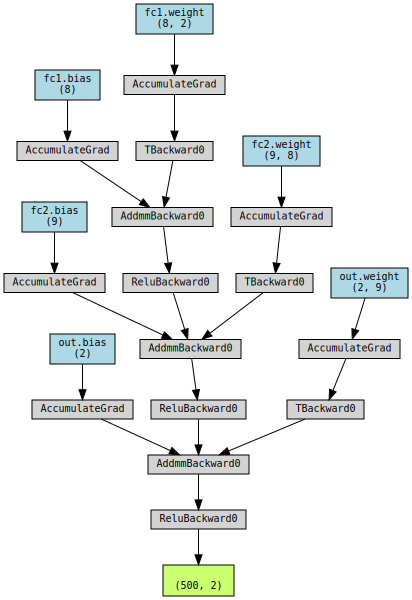

In [22]:
# Visualize model
from torchviz import make_dot
make_dot(model(X_train), params=dict(model.named_parameters()))

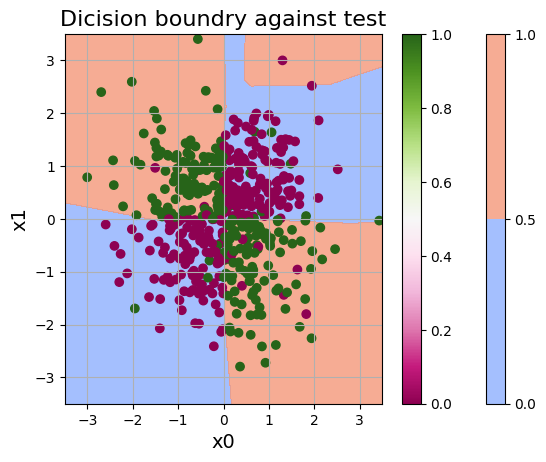

In [23]:
x_mesh, y_mesh = np.meshgrid(
                            np.arange(-3.5, 3.5, 0.003),
                            np.arange(-3.5, 3.5, 0.003))

grid_points = np.c_[x_mesh.ravel(), y_mesh.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

with torch.no_grad():
    model.eval()
    predictions = model(grid_tensor)
    predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()

z = predicted_labels.reshape(x_mesh.shape)
plt.contourf(x_mesh, y_mesh, z, levels=1, cmap='coolwarm', alpha=0.8)
plt.colorbar()
plt.scatter(test['x0'], test['x1'], c=test['y'], cmap='PiYG')
plt.colorbar()
#plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='PiYG')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('Dicision boundry against test', fontsize=16)
plt.show()

### C)

I chose the adam (adaptive movement) optimizer. The method uses concepts like gradient descent, momentum and rms propagation. This makes the gradient descent faster than with pure stochastic gradient descent, and it has by my understanding generally a better chance of finding global minima and not getting "stuck" in local minima. The momentum makes the optimizer take bigger steps if the gradient has had the same direction for previous iterations. This makes it able to converge faster than a locked learning rate. SGD has a locked learning rate, and takes steps that are the same lenght given the same gradient. It had however been shown that SGD is more generalizeable.

### D)
The scheduler made it possible to have larger steps in the beginning, while still not overshooting the minima. This made the model converge faster. I don't think the warmup had any effect, but given the dataset size that it's not surprising. 

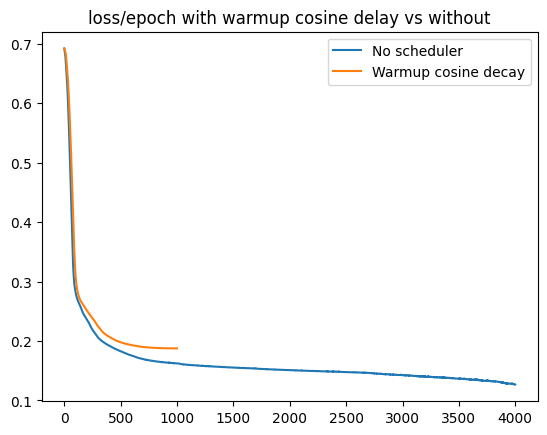

In [24]:

plt.plot(range(epochs), losses, label='No scheduler')
plt.plot(range(epochs_scheduler), losses_scheduler, label='Warmup cosine decay')
plt.legend()
plt.title('loss/epoch with warmup cosine delay vs without')
plt.show()

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts (~30 days * 50 submissions = 1500 total attempts per student).

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/6610d6c6ba314eac9ead0b7a47695700)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.


In [25]:
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)

In [26]:
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [27]:
# The dataset is heavy. Applying clustering directly on the dataset is not feasible, I guess. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


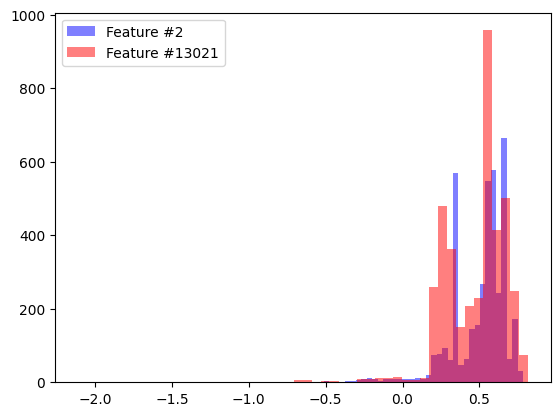

In [28]:
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()

In [29]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7


In [30]:
col = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
                '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a', '#33a02c'])

In [31]:
# Reducing to 50 dimensions with PCA
X = data.drop(columns='ID')
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]
X.head

<bound method NDFrame.head of          0         1         2         3         4         5         6      \
0    -0.190482  0.142813 -0.173180 -0.210126  0.151852  0.108087  0.159326   
1     0.082781 -0.008516  0.062804 -0.694855  0.009569  0.012349  0.035792   
2     0.085357 -0.135819 -0.129355 -0.080945 -0.136264  0.051985 -0.119306   
3     0.084449  0.085804  0.082797  0.102796  0.075888  0.041607  0.121257   
4     0.155248 -0.032816 -0.306662  0.224187 -0.033177  0.134548  0.185672   
...        ...       ...       ...       ...       ...       ...       ...   
3995 -0.164108 -0.162753 -0.156289  0.233205 -0.163198 -0.197479 -0.146241   
3996 -0.120590 -0.119235  0.178193 -0.064362 -0.119681  0.137003 -0.102723   
3997  0.136991  0.147643 -0.245699 -0.197290  0.147198  0.112917 -0.235651   
3998  0.050687  0.052041  0.058505  0.106915  0.051596  0.017315  0.068553   
3999  0.087486 -0.022758 -0.352763  0.088967 -0.241650  0.056562  0.055346   

         7         8         9   

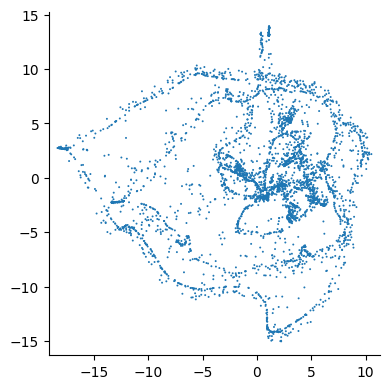

In [32]:
# PCA plot
X2 = np.dot(U, np.diag(s))[:,:2]
plt.figure(figsize=(4,4))
plt.axis('equal')
plt.scatter(X2[:,0], X2[:,1], s=2, edgecolors='none')
sns.despine()
plt.tight_layout()

=============== t-SNE v1.2.1 ===============
fast_tsne data_path: data_2024-10-14 14:25:51.119785-54731974.dat
fast_tsne result_path: result_2024-10-14 14:25:51.119785-54731974.dat
fast_tsne nthreads: 12
Read the following parameters:
	 n 4000 by d 16384 dataset, theta 0.500000,
	 perplexity 500.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 333.333333, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 75000,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, interval_per_integer 1.000000, min_num_intervals 50, t-dist df 1.000000
Read the 4000 x 16384 data matrix successfully. X[0,0] = 0.314365
Read the initialization successfully.
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problem

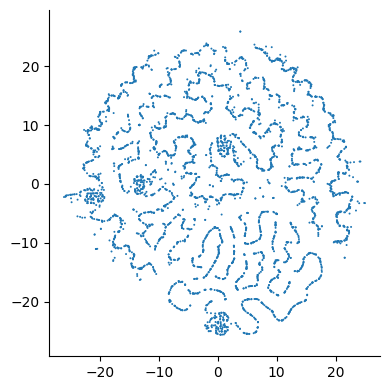

In [33]:
# t-sne plot
from fast_tsne import fast_tsne

X100 = np.dot(U, np.diag(s))[:,:100]
X = data.drop(columns='ID')

Z = fast_tsne(X, perplexity=50)
plt.figure(figsize=(4,4))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolors='none')
sns.despine()
plt.tight_layout()

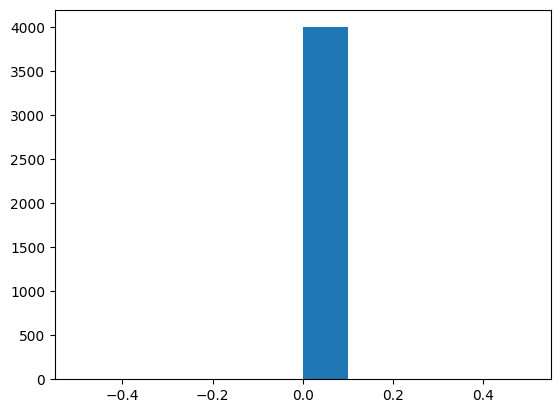

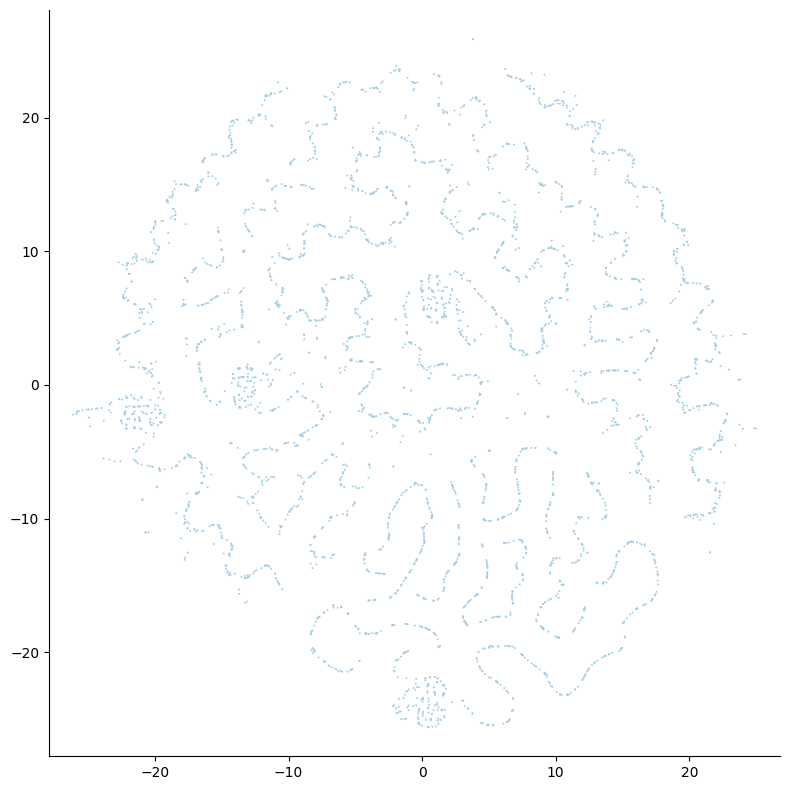

In [34]:
# Clustering with DBSCAN
from sklearn.cluster import DBSCAN

Z50 = Z[:,:49]
db = DBSCAN(eps=3.5).fit(Z)

plt.hist(db.labels_)
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], c=col[db.labels_], s=2, edgecolors='none')
sns.despine()
plt.tight_layout()

In [35]:
# Make submission
submission = pd.DataFrame(db.labels_.T)
submission.index.name = 'ID'
submission.columns = ['cluster']
submission.to_csv('submission.csv')

#rsync -aP antilope@188.113.66.197:/home/antilope/repos/tdt4172/Assignment2/submission.csv ~/Downloads/

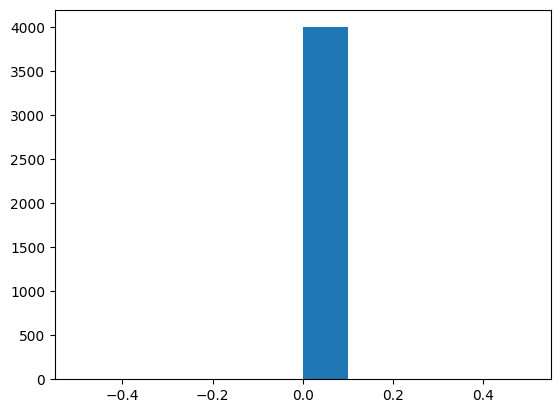

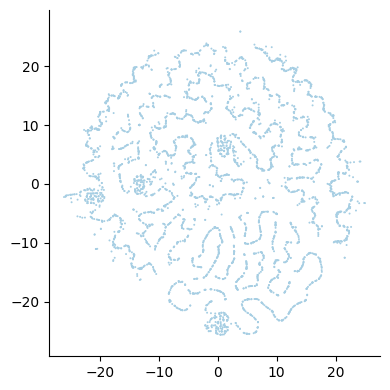

In [36]:
Z200 = Z[:,:200]
db = DBSCAN(eps=4).fit(Z200)

plt.hist(db.labels_)
plt.figure(figsize=(4,4))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], c=col[db.labels_], s=2, edgecolors='none')
sns.despine()
plt.tight_layout()

---

/home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 120 with accuracies 
[5.50647969e-15 4.16673854e-05 9.15839015e-06 1.43112698e-05]
not reaching the requested tolerance 1.6689300537109375e-05.
Use iteration 120 instead with accuracy 
1.628426133158914e-05.

  _, diffusion_map = lobpcg(
/home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.27618623e-15 4.16673852e-05 9.15839164e-06 1.43112695e-05]
not reaching the requested tolerance 1.6689300537109375e-05.
  _, diffusion_map = lobpcg(


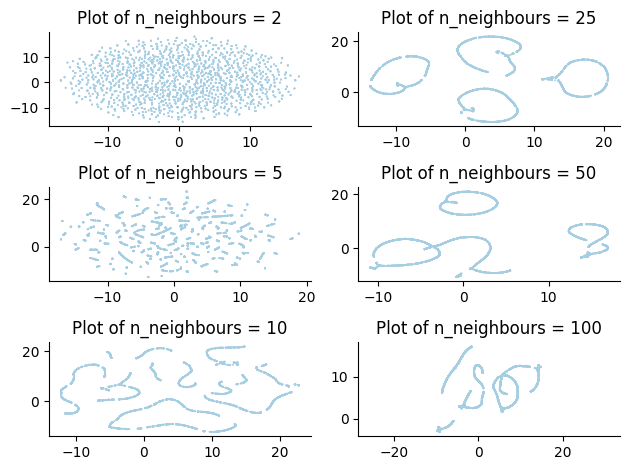

CPU times: user 8min 4s, sys: 2.73 s, total: 8min 7s
Wall time: 5min 56s


In [37]:
%%time
from umap import UMAP

tuning_list = [2, 5, 10, 25, 50, 100]
X = data.drop(columns='ID')
fig, axs = plt.subplots(3, 2)
plt.axis('equal')

for i, n_neighbours in enumerate(tuning_list):
    umap = UMAP(n_neighbors=n_neighbours)
    umap.fit(X)
    embedding = umap.embedding_

    if i>2: 
        j=1
        i=i-3
    else: j=0

    axs[i][j].scatter(embedding[:,0], embedding[:,1], c=col[db.labels_], s=2, edgecolors='none')
    axs[i][j].set_title(f'Plot of n_neighbours = {n_neighbours}')

sns.despine()
plt.tight_layout()
plt.show()

/home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float32, 0d, C), Literal[int](0))
 
There are 22 candidate implementations:
  - Of which 20 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float32, 0d, C), int64)':
   No match.
  - Of which 1 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 211.
    With argument(s): '(array(float32, 0d, C), int64)':
   Rejected as the implementation raised a specific error:
     NumbaTypeError: cannot index array(float32, 0d, C) with 1 indices: [int64]
  raised from /home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/numba/core/typing/arraydecl.py:133
  - Of which 1 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 211.
    With argument(s): '(array(float32, 0d, C), Literal[int](0))':
   Rejected as the implementation raised a specific error:
     NumbaTypeError: cannot index array(float32, 0d, C) with 1 indices: [Literal[int](0)]
  raised from /home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/numba/core/typing/arraydecl.py:133

During: typing of intrinsic-call at /home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/gpumap/smooth_knn_dist_gpu.py (143)
During: typing of static-get-item at /home/antilope/pyenv/tdt4172/assignment2/lib/python3.10/site-packages/gpumap/smooth_knn_dist_gpu.py (143)

File "../../../pyenv/tdt4172/assignment2/lib/python3.10/site-packages/gpumap/smooth_knn_dist_gpu.py", line 143:
def smooth_knn_dist_cuda(
    <source elided>
            # FIXME related to cupy bug https://github.com/cupy/cupy/issues/2205
            mean = distances_mean[0]
            ^


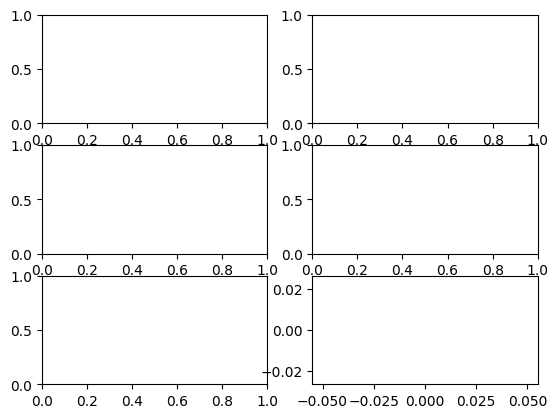

In [38]:
# GPU UMAP
# %%time
# from gpumap import GPUMAP

# tuning_list = [2, 5, 10, 25, 50, 100]
# X = data.drop(columns='ID')
# fig, axs = plt.subplots(3, 2)
# plt.axis('equal')

# for i, n_neighbours in enumerate(tuning_list):
#     umap = GPUMAP(n_neighbors=n_neighbours)
#     umap.fit(X)
#     embedding = umap.embedding_

#     if i>2: 
#         j=1
#         i=i-3
#     else: j=0

#     axs[i][j].scatter(embedding[:,0], embedding[:,1], c=col[db.labels_], s=2, edgecolors='none')
#     axs[i][j].set_title(f'Plot of n_neighbours = {n_neighbours}')

# sns.despine()
# plt.tight_layout()
# plt.show()

In [39]:
X = data.drop(columns='ID')
umap = UMAP(n_neighbors=25)
umap.fit(X)

UMAP(n_neighbors=25, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [40]:
embedding = umap.embedding_
embedding.shape

(4000, 2)

In [43]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=3.3).fit(embedding)

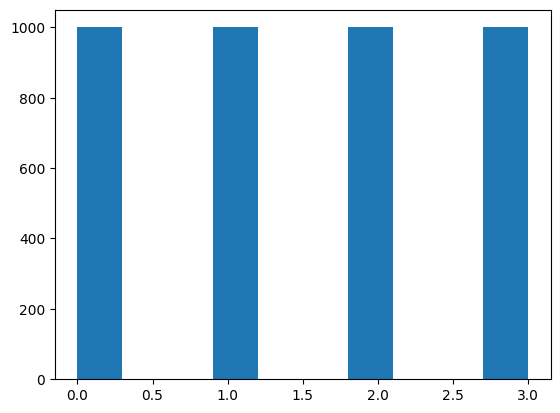

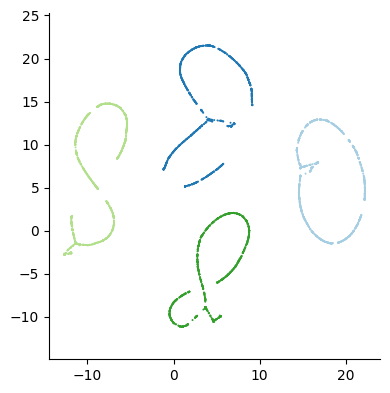

In [44]:
plt.hist(db.labels_)
plt.figure(figsize=(4,4))
plt.axis('equal')
plt.scatter(embedding[:,0], embedding[:,1], c=col[db.labels_], s=2, edgecolors='none')
sns.despine()
plt.tight_layout()

---
2. **Discussion Questions**:
   - **Dimensionality Reduction**: The final dim.red. technique I used was UMAP. This made me identify 4 clusters. I dont really know why this worked better than tsne. Both UMAP and t-SNE are more modern than PCA. PCA reduces dimensions by 'removing' the dimensions that carry the least amount of information. t-SNE is an iterative mothod where datapoints are optimized (gradient descent) to have the same 'position' in a t-distribution (similar to a gaussian distribution.) in a lower dimension as they had in a higher dimension. UMAP
   
   Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.


---

## 🎯 Note: Clustering Accuracy Evaluation


The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation focuses solely on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [ ]:
from typing import Any
import numpy as np
import sklearn.metrics
import scipy.optimize

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy


In [ ]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

1.0

In [ ]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.3333333333333333

In [ ]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.5